In [27]:
# FOR GOOGLE COLAB
from google.colab import drive
drive.mount('/content/drive')
!pip install xgboost
!pip install catboost
!pip install lightgbm

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_curve, auc, confusion_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [29]:
# numerical data processing
def _transfrom_basic(df ):
    df['is_fresher'] = df['previous_year_rating'].apply(lambda x: 1 if x ==0 else 0 )
    df['age_2'] = pd.cut( x=df['age'], bins=[20, 29, 39, 49], labels=['0', '1', '2'] )
    return df


class AddStatisticFt(BaseEstimator, TransformerMixin):
    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        inp = X.copy()
        pro1 = np.expand_dims( np.mean(inp, axis = 1) , -1)
        pro2 = np.expand_dims( np.std(inp, axis = 1) , -1)
        pro3 = np.expand_dims( np.median(inp, axis = 1) , -1)
        pro4 = np.expand_dims( np.var(inp, axis = 1) , -1)
        return np.concatenate([inp, pro1, pro2, pro3, pro4], axis= 1) 


# Multicolumn Label encoder
class MultiColumnLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode
        self.dict_encoder = {}

    def fit(self,X,y=None):
        for i in self.columns:
            encoder = preprocessing.LabelEncoder()
            encoder.fit(X[i].astype(str))
            self.dict_encoder[i] = encoder
        return self # not relevant here

    def transform(self,X):
        output = X[self.columns].copy()
        for i in self.columns:
            output[i] = self.dict_encoder[i].transform(output[i])
        return output

def evaluate_model(model, X, y):
    try:
        y_pred = model.predict_proba(X)[:, 1]
    except:
        y_pred = model.predict(X)

    fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y, y_pred)
    auc_s = auc(fpr_rt_lm, tpr_rt_lm)
    print('AUC: ', auc_s)
    print('Gini: ', 2*auc_s - 1)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

In [30]:
folder_path = '/content/drive/MyDrive/Data/colabs_data/HR_pred'
train_path = folder_path + '/train_LZdllcl.csv'
test_path = folder_path +  '/test_2umaH9m.csv'

In [31]:
# Data loading
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [32]:
# cols classifying
cols_id = ['employee_id']
col_label = 'is_promoted'
cols_ft = [col for col in df_train.columns if col not in cols_id + [col_label] ]
cols_ft_cat = [col for col in df_train.columns if col not in cols_id + [col_label] and df_train[col].dtype=='object']
cols_ft_num = [col for col in cols_ft if col not in cols_ft_cat] 

In [33]:
# for i in cols_ft_cat:
#     print( df_train.groupby(i)['employee_id'].count().sort_values(ascending = False) )
# # => dữ liệu khá sạch

In [34]:
cols_ft += ['is_fresher', 'age_2']
cols_ft_cat += ['age_2']
cols_ft_num += ['is_fresher']

df_train = _transfrom_basic(df_train)
df_test = _transfrom_basic(df_test)

In [35]:
X_train, X_test, y_train, y_test = train_test_split( df_train[cols_ft], df_train[col_label], test_size=0.33, random_state=42)

0:	learn: 0.5623559	total: 20.6ms	remaining: 10.1s
1:	learn: 0.5003542	total: 40ms	remaining: 9.85s
2:	learn: 0.4605455	total: 59.6ms	remaining: 9.76s
3:	learn: 0.4278511	total: 80.2ms	remaining: 9.83s
4:	learn: 0.4148983	total: 100ms	remaining: 9.79s
5:	learn: 0.4019507	total: 119ms	remaining: 9.7s
6:	learn: 0.3894352	total: 139ms	remaining: 9.69s
7:	learn: 0.3764763	total: 160ms	remaining: 9.72s
8:	learn: 0.3518054	total: 180ms	remaining: 9.71s
9:	learn: 0.3442462	total: 200ms	remaining: 9.7s
10:	learn: 0.3351796	total: 227ms	remaining: 9.99s
11:	learn: 0.3331937	total: 248ms	remaining: 9.97s
12:	learn: 0.3299113	total: 265ms	remaining: 9.79s
13:	learn: 0.3262050	total: 286ms	remaining: 9.79s
14:	learn: 0.3238053	total: 306ms	remaining: 9.76s
15:	learn: 0.3161706	total: 325ms	remaining: 9.72s
16:	learn: 0.3117118	total: 345ms	remaining: 9.67s
17:	learn: 0.3106554	total: 364ms	remaining: 9.62s
18:	learn: 0.3062099	total: 385ms	remaining: 9.62s
19:	learn: 0.3051175	total: 406ms	remaini

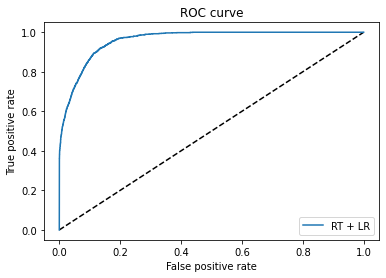

Train AUC
AUC:  0.9585000922349353
Gini:  0.9170001844698705


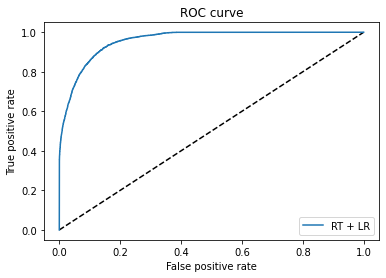

In [40]:
# Model compile
estimators = [
    (
        'xgb', XGBClassifier(learning_rate =0.1, n_estimators=494, max_depth=5, subsample = 0.70, verbosity = 0,
              scale_pos_weight = 2.5, updater ="grow_histmaker", base_score  = 0.2)
    ),
    (
        'catboost', CatBoostClassifier(learning_rate=0.15, n_estimators=494, subsample=0.085, max_depth=5, scale_pos_weight=2.5)
    ),
    (
        'lightgbm', LGBMClassifier(subsample_freq = 2,  objective ="binary",  importance_type = "gain",  verbosity = -1,   max_bin = 60,  
                              num_leaves = 300,  boosting_type = 'dart',  learning_rate=0.15,   n_estimators=494,  
                              max_depth=5,   scale_pos_weight=2.5)
    ),

]
clf = ensemble.VotingClassifier(estimators= estimators, voting='soft',weights=[5,5,5.2])
# ensemble.StackingClassifier(
#     estimators=estimators, final_estimator=LogisticRegression(), 
#     cv = 10, n_jobs = -1
# )

p_cat = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')) ,
    ('encode', preprocessing.OneHotEncoder()) #  MultiColumnLabelEncoder(columns = cols_ft_cat )
])
p_num = Pipeline([
    ('fillna', SimpleImputer(strategy='constant', fill_value=0)),
    ('norm', preprocessing.RobustScaler()),
    # ('add_stats',AddStatisticFt())
])
p1 = ColumnTransformer([
    ('cat', p_cat, cols_ft_cat ),
    ('num', p_num, cols_ft_num)
])

p1.fit(pd.concat([df_train[cols_ft], df_test[cols_ft]]))

pipe = Pipeline([
    ('transformer', p1),
    ('predictor', clf)
])

#### Fitting
pipe.fit(df_train[cols_ft], df_train[col_label])
# pipe.fit(X_train, y_train)

# Evaluating
print('Test AUC')
evaluate_model(pipe, X_test[cols_ft], y_test)

print('Train AUC')
evaluate_model(pipe, X_train[cols_ft], y_train)

In [41]:
df_test['is_promoted'] = pipe.predict(df_test[cols_ft])

In [43]:
# df_test[['employee_id', 'is_promoted']].to_csv( folder_path + '/submission.csv', index = False)
df_test[['employee_id', 'is_promoted']].to_csv( 'submission.csv', index = False)